# Demonstate an Actor/Critic class of RL agent
We must use two classes of actors and use a different strategy for training the agents than the REINFORCE demo.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from hydronet.rl.tf.env import SimpleEnvironment
from hydronet.rl.rewards.mpnn import MPNNReward
from hydronet.rl.tf.agents import ConstrainedRandomPolicy
from hydronet.rl.tf.networks import GCPNActorNetwork, GCPNCriticNetwork
from hydronet.mpnn.layers import custom_objects
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver
from tf_agents.policies.policy_saver import PolicySaver
from tf_agents.agents import PPOClipAgent
from pathlib import Path
from tqdm import tqdm
import tensorflow as tf
import pandas as pd
import numpy as np

Configuration

In [2]:
mpnn_path = Path() / '..' / '..' / 'challenge-2' / 'best-model' / 'best_model.h5'

## Make the Environment
Use the energy of the cluster predicted with our MPNN as a reward

In [3]:
model = tf.keras.models.load_model(mpnn_path, custom_objects=custom_objects)
reward = MPNNReward(model, per_water=False)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [4]:
env = SimpleEnvironment(maximum_size=10, reward=reward, only_last=True)
tf_env = TFPyEnvironment(env)

## Build the Policies
We are going to compare against a baseline policy that picks random setsp

### Make a Random Policy
Using our random policy that constrains guesses to actions that produce valid graphs.

In [5]:
random_policy = ConstrainedRandomPolicy(
    time_step_spec=tf_env.time_step_spec(),
    action_spec=tf_env.action_spec()
)

### Make the RL Agent
Use the `GCPNActorNetwork` to predict actions and the `GCPNCriticNetwork` to score values

In [6]:
actor_net = GCPNActorNetwork(tf_env.observation_spec(), tf_env.action_spec(), tf_env.reset(), 
                             num_messages=8, node_features=64, graph_features=False,
                            output_layers=3)

In [8]:
critic_net = GCPNCriticNetwork(tf_env.observation_spec(), tf_env.reset(), num_messages=6)

In [9]:
tf_agent = PPOClipAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    actor_net=actor_net,
    value_net=critic_net,
    optimizer=tf.keras.optimizers.Adam(1e-3),
    normalize_observations=False,
    entropy_regularization=1e-4,
    discount_factor=1.,
)
tf_agent.initialize()

## Drive it to Make some Data
Use the TFUniformReplyBuffer to keep track of data

In [10]:
buffer = TFUniformReplayBuffer(
    tf_agent.collect_data_spec,
    batch_size=1,
    max_length=1024,
)

In [11]:
driver = DynamicEpisodeDriver(tf_env, tf_agent.collect_policy, [buffer.add_batch], num_episodes=8)

Function to measure the average return

In [12]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

Get the average return for a random policy

In [13]:
%%time
random_return = compute_avg_return(tf_env, random_policy, 64)
print(f'Random return: {random_return:.1f}')

C:\Users\ward6\Miniconda3\envs\hydronet\lib\site-packages\tensorflow\python\keras\engine\functional.py:588: UserWarning: Input dict contained keys ['n_waters', 'n_atoms', 'n_bonds', 'bond_graph_indices'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Random return: 87.5
Wall time: 7.52 s


And the agent before we train it

In [14]:
%%time
agent_return = compute_avg_return(tf_env, tf_agent.collect_policy, 32)
print(f'Untrained Agent return with randomized policy: {agent_return:.1f}')

Untrained Agent return with randomized policy: 83.6
Wall time: 37.8 s


Run until we fill the buffer

In [15]:
%%time
state = tf_env.reset()
while buffer.num_frames() < buffer.capacity:
    state, _ = driver.run(state)

Wall time: 1min 44s


Train over many iterations

In [15]:
train_loss = None
track = []
pbar = tqdm(range(32))
for epoch in pbar:
    # Compute the return of the greedy policy
    greedy_return = compute_avg_return(tf_env, tf_agent.policy, 1)
    avg_return = compute_avg_return(tf_env, tf_agent.collect_policy, 32)
    step_info = {'greedy_return': greedy_return, 'avg_return': avg_return, 'epoch': epoch}
    
    # Collect a few episodes using collect_policy and save to the replay buffer.
    init_ts = tf_env.reset()
    final_ts, _ = driver.run(init_ts)

    # Use data from the buffer and update the agent's network.
    dataset = buffer.as_dataset(sample_batch_size=64, num_steps=2, num_parallel_calls=4)
    for (trajs, _), step in zip(dataset, range(16)):
        train_loss = tf_agent.train(trajs)

        # Store step information
        step_info = {'return': avg_return, 'epoch': epoch}
        step_info.update(dict(zip(train_loss.extra._fields, map(float, tuple(train_loss.extra)))))
        step_info['loss'] = train_loss.loss.numpy()
        step_info['step'] = step

        track.append(step_info)
        
        # Update the progress bar
        pbar.set_description(f'loss: {train_loss.loss:.2e} - return: {avg_return:.1f} - step: {step}')

  0%|          | 0/32 [00:00<?, ?it/s]

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


loss: 3.12e-02 - return: 94.8 - step: 15: 100%|██████████| 32/32 [29:24<00:00, 55.15s/it] 


Measure the performance after training

In [16]:
agent_return = compute_avg_return(tf_env, tf_agent.collect_policy, 32)
print(f'Agent return with randomized policy: {agent_return:.1f}')

Agent return with randomized policy: 94.8


## Save the Model and Training Performance
So we can analyze them later

In [17]:
train_info = pd.DataFrame(track)
train_info.to_csv('train_info.csv', index=False)

## Make a Simple Plot
See if the return is increasing over time

Text(0, 0.5, 'Return')

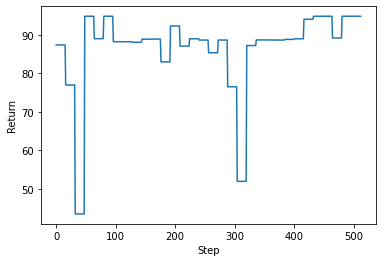

In [18]:
fig, ax = plt.subplots()

ax.plot(train_info['return'])
ax.set_xlabel('Step')
ax.set_ylabel('Return')

Text(0, 0.5, 'Loss')

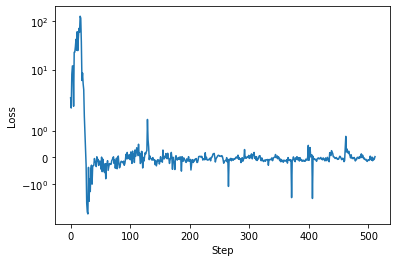

In [19]:
fig, ax = plt.subplots()

ax.plot(train_info['loss'])

ax.set_yscale('symlog')
ax.set_xlabel('Step')
ax.set_ylabel('Loss')

Plot some trajectories

In [20]:
def get_trajectories(environment, policy, num_episodes=10) -> pd.DataFrame:
    """Get trajectory of energy wrt step
    
    Args:
        environment: Water cluster environment
        policy: Policy to execute
    Returns:
        List of trajectories
    """
    output = []
    for e in range(num_episodes):
        time_step = environment.reset()
        step = 0
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            graph = tf_env.pyenv.envs[0].get_state()
            output.append({
                'episode': e,
                'step': step,
                'graph': graph,
                'energy': -reward(graph),
                'size': len(graph),
                'reward': float(-1 * time_step.reward.numpy()),
            })
            step += 1

    return pd.DataFrame(output)

In [21]:
%%time
rl_traj = get_trajectories(tf_env, tf_agent.collect_policy, 32)

CPU times: user 8.29 s, sys: 185 ms, total: 8.48 s
Wall time: 7.93 s


In [22]:
%%time
greedy_traj = get_trajectories(tf_env, tf_agent.policy, 1)

CPU times: user 257 ms, sys: 8.17 ms, total: 265 ms
Wall time: 247 ms


In [23]:
%%time
random_traj = get_trajectories(tf_env, random_policy, 32)

CPU times: user 4.81 s, sys: 58.6 ms, total: 4.86 s
Wall time: 4.47 s


Lowest energy from RL: -94.79
Lowest energy from Random: -92.55


Text(0, 0.5, 'Count')

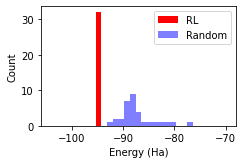

In [24]:
fig, ax = plt.subplots(figsize=(3.5, 2.2))

best_energy_rl = rl_traj.query('size<=10').groupby('episode').min()['energy']
best_energy_rand = random_traj.query('size<=10').groupby('episode')['energy'].min()
print(f'Lowest energy from RL: {min(best_energy_rl):.2f}')
print(f'Lowest energy from Random: {min(best_energy_rand):.2f}')
bins = np.linspace(
    min(best_energy_rand.min(), best_energy_rl.min()) * 1.1,
    max(best_energy_rand.max(), best_energy_rl.max()) * 0.9,
    32
)

ax.hist(best_energy_rl.values, bins=bins, color='r', label='RL')
ax.hist(best_energy_rand, bins=bins, alpha=0.5, color='b', label='Random')

ax.legend()
ax.set_xlabel('Energy (Ha)')
ax.set_ylabel('Count')

Save solutions to disk for later analysis

In [32]:
rl_traj.to_pickle('rl_outputs.pkl')
random_traj.to_pickle('random_outputs.pkl')